In [72]:
import sys
sys.path.append("..")
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from evaluate import IoU_value
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from interpret import show
from interpret.blackbox import LimeTabular
from interpret.blackbox import ShapKernel
import pandas as pd
import numpy as np
import xgboost
from interpret.glassbox import ExplainableBoostingClassifier

pd.options.display.max_columns = None
from transform import init_transform
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
def get_ks(FPR, recall, thresholds):
    KS_max = 0
    best_thr = 0
    tpr = recall
    for i in range(len(FPR)):
        if(i == 0):
            KS_max = tpr[i] - FPR[i]
            best_thr = thresholds[i]
        elif (tpr[i] - FPR[i] > KS_max):
            KS_max = tpr[i] - FPR[i]
            best_thr = thresholds[i]
    
    print('最大KS为：', KS_max)
    print('最佳阈值为：', best_thr)

In [73]:
df = pd.read_csv("../train/true_dataset/lending club/lending_club_processed.csv",index_col=0)
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,target
0,15000.0,15000.0,15000.0,60.0,5.32,451.73,0.0,0.0,10.0,0.0,105000.0,1.0,1.0,26,14.24,0.0,775.0,779.0,0.0,34.224381,10.0,0.0,13367.0,38.9,20.0,0.0,0.00,0.00,15838.304347,15838.30,15000.00,838.30,0.0,0.0,0.0,719.0,715.0,0.0,0.0,0.0,0.0,60303.0,1.0,4.0,3.0,3.0,5.0,37177.0,87.0,0.0,1.0,7277.0,66.0,34400.0,0.0,0.0,0.0,4.0,6030.0,15033.0,47.1,0.0,0.0,142.0,210.0,22.0,5.0,2.0,22.0,6.522204,0.0,3.0,3.0,3.0,4.0,11.0,5.0,7.0,3.0,10.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,155369.0,50544.0,28400.0,42806.0,0.0,0.0,0.0
1,4800.0,4800.0,4800.0,60.0,7.99,150.40,0.0,4.0,10.0,2.0,110000.0,2.0,2.0,6,16.29,0.0,790.0,794.0,2.0,34.224381,11.0,0.0,46669.0,42.4,30.0,0.0,1729.75,1729.75,3607.470000,3607.47,3070.25,537.22,0.0,0.0,0.0,649.0,645.0,0.0,0.0,0.0,0.0,316154.0,0.0,3.0,0.0,2.0,17.0,21736.0,53.0,2.0,6.0,6676.0,45.0,119000.0,4.0,0.0,4.0,8.0,28741.0,72306.0,16.7,0.0,0.0,63.0,290.0,7.0,7.0,3.0,7.0,5.000000,0.0,4.0,5.0,6.0,16.0,5.0,7.0,22.0,5.0,11.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,509315.0,68405.0,85000.0,40715.0,0.0,0.0,1.0
2,15000.0,15000.0,15000.0,60.0,10.49,487.47,1.0,11.0,10.0,0.0,75000.0,0.0,0.0,35,10.38,0.0,705.0,709.0,0.0,36.000000,9.0,0.0,4289.0,39.0,57.0,1.0,0.00,0.00,17204.184465,17204.18,15000.00,2204.18,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,316.0,83201.0,2.0,3.0,2.0,5.0,2.0,13139.0,76.0,1.0,3.0,2804.0,61.0,11000.0,0.0,1.0,3.0,8.0,10400.0,3496.0,44.5,0.0,0.0,266.0,113.0,4.0,2.0,1.0,4.0,11.000000,1.0,1.0,3.0,1.0,5.0,47.0,5.0,9.0,3.0,9.0,0.0,0.0,0.0,3.0,94.7,0.0,0.0,0.0,100922.0,17428.0,6300.0,17371.0,0.0,0.0,0.0
3,3000.0,3000.0,3000.0,60.0,5.32,90.35,0.0,0.0,9.0,0.0,78000.0,2.0,2.0,42,22.11,0.0,770.0,774.0,0.0,57.000000,14.0,0.0,12410.0,20.2,24.0,0.0,0.00,0.00,3035.931710,3035.93,3000.00,35.93,0.0,0.0,0.0,754.0,750.0,0.0,0.0,0.0,0.0,122270.0,1.0,2.0,0.0,1.0,17.0,11256.0,43.0,1.0,2.0,10269.0,24.0,61300.0,0.0,0.0,3.0,3.0,8734.0,48890.0,20.2,0.0,0.0,108.0,155.0,2.0,2.0,4.0,2.0,10.000000,0.0,2.0,2.0,10.0,13.0,4.0,10.0,16.0,2.0,14.0,0.0,0.0,0.0,1.0,95.8,0.0,0.0,0.0,254797.0,23666.0,61300.0,56497.0,0.0,0.0,0.0
4,8000.0,8000.0,8000.0,60.0,13.49,271.45,2.0,21.0,4.0,0.0,55000.0,2.0,3.0,24,9.56,1.0,720.0,724.0,1.0,14.000000,14.0,0.0,20549.0,31.0,25.0,0.0,0.00,0.00,8421.381904,8421.38,8000.00,421.38,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,0.0,113222.0,0.0,2.0,0.0,1.0,22.0,4812.0,65.0,0.0,4.0,10882.0,34.0,66300.0,2.0,0.0,4.0,6.0,8087.0,31851.0,39.2,0.0,0.0,81.0,120.0,13.0,10.0,1.0,13.0,0.000000,0.0,4.0,4.0,7.0,11.0,7.0,11.0,17.0,4.0,14.0,0.0,0.0,0.0,1.0,96.0,14.3,0.0,0.0,163222.0,25361.0,52400.0,7462.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [74]:
df.drop(columns="target",inplace=True)
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,15000.0,15000.0,15000.0,60.0,5.32,451.73,0.0,0.0,10.0,0.0,105000.0,1.0,1.0,26,14.24,0.0,775.0,779.0,0.0,34.224381,10.0,0.0,13367.0,38.9,20.0,0.0,0.00,0.00,15838.304347,15838.30,15000.00,838.30,0.0,0.0,0.0,719.0,715.0,0.0,0.0,0.0,0.0,60303.0,1.0,4.0,3.0,3.0,5.0,37177.0,87.0,0.0,1.0,7277.0,66.0,34400.0,0.0,0.0,0.0,4.0,6030.0,15033.0,47.1,0.0,0.0,142.0,210.0,22.0,5.0,2.0,22.0,6.522204,0.0,3.0,3.0,3.0,4.0,11.0,5.0,7.0,3.0,10.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,155369.0,50544.0,28400.0,42806.0,0.0,0.0
1,4800.0,4800.0,4800.0,60.0,7.99,150.40,0.0,4.0,10.0,2.0,110000.0,2.0,2.0,6,16.29,0.0,790.0,794.0,2.0,34.224381,11.0,0.0,46669.0,42.4,30.0,0.0,1729.75,1729.75,3607.470000,3607.47,3070.25,537.22,0.0,0.0,0.0,649.0,645.0,0.0,0.0,0.0,0.0,316154.0,0.0,3.0,0.0,2.0,17.0,21736.0,53.0,2.0,6.0,6676.0,45.0,119000.0,4.0,0.0,4.0,8.0,28741.0,72306.0,16.7,0.0,0.0,63.0,290.0,7.0,7.0,3.0,7.0,5.000000,0.0,4.0,5.0,6.0,16.0,5.0,7.0,22.0,5.0,11.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,509315.0,68405.0,85000.0,40715.0,0.0,0.0
2,15000.0,15000.0,15000.0,60.0,10.49,487.47,1.0,11.0,10.0,0.0,75000.0,0.0,0.0,35,10.38,0.0,705.0,709.0,0.0,36.000000,9.0,0.0,4289.0,39.0,57.0,1.0,0.00,0.00,17204.184465,17204.18,15000.00,2204.18,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,316.0,83201.0,2.0,3.0,2.0,5.0,2.0,13139.0,76.0,1.0,3.0,2804.0,61.0,11000.0,0.0,1.0,3.0,8.0,10400.0,3496.0,44.5,0.0,0.0,266.0,113.0,4.0,2.0,1.0,4.0,11.000000,1.0,1.0,3.0,1.0,5.0,47.0,5.0,9.0,3.0,9.0,0.0,0.0,0.0,3.0,94.7,0.0,0.0,0.0,100922.0,17428.0,6300.0,17371.0,0.0,0.0
3,3000.0,3000.0,3000.0,60.0,5.32,90.35,0.0,0.0,9.0,0.0,78000.0,2.0,2.0,42,22.11,0.0,770.0,774.0,0.0,57.000000,14.0,0.0,12410.0,20.2,24.0,0.0,0.00,0.00,3035.931710,3035.93,3000.00,35.93,0.0,0.0,0.0,754.0,750.0,0.0,0.0,0.0,0.0,122270.0,1.0,2.0,0.0,1.0,17.0,11256.0,43.0,1.0,2.0,10269.0,24.0,61300.0,0.0,0.0,3.0,3.0,8734.0,48890.0,20.2,0.0,0.0,108.0,155.0,2.0,2.0,4.0,2.0,10.000000,0.0,2.0,2.0,10.0,13.0,4.0,10.0,16.0,2.0,14.0,0.0,0.0,0.0,1.0,95.8,0.0,0.0,0.0,254797.0,23666.0,61300.0,56497.0,0.0,0.0
4,8000.0,8000.0,8000.0,60.0,13.49,271.45,2.0,21.0,4.0,0.0,55000.0,2.0,3.0,24,9.56,1.0,720.0,724.0,1.0,14.000000,14.0,0.0,20549.0,31.0,25.0,0.0,0.00,0.00,8421.381904,8421.38,8000.00,421.38,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,0.0,113222.0,0.0,2.0,0.0,1.0,22.0,4812.0,65.0,0.0,4.0,10882.0,34.0,66300.0,2.0,0.0,4.0,6.0,8087.0,31851.0,39.2,0.0,0.0,81.0,120.0,13.0,10.0,1.0,13.0,0.000000,0.0,4.0,4.0,7.0,11.0,7.0,11.0,17.0,4.0,14.0,0.0,0.0,0.0,1.0,96.0,14.3,0.0,0.0,163222.0,25361.0,52400.0,7462.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [115]:
#数据集归一化
# df_norm = (df - df.min()) / (df.max() - df.min())
df_norm = df
df_norm

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,target
0,15000.0,15000.0,15000.0,60.0,5.32,451.73,0.0,0.0,10.0,0.0,105000.0,1.0,1.0,26,14.24,0.0,775.0,779.0,0.0,34.224381,10.0,0.0,13367.0,38.9,20.0,0.0,0.00,0.00,15838.304347,15838.30,15000.00,838.30,0.0,0.0,0.0,719.0,715.0,0.0,0.0,0.0,0.0,60303.0,1.0,4.0,3.0,3.0,5.0,37177.0,87.0,0.0,1.0,7277.0,66.0,34400.0,0.0,0.0,0.0,4.0,6030.0,15033.0,47.1,0.0,0.0,142.0,210.0,22.0,5.0,2.0,22.0,6.522204,0.0,3.0,3.0,3.0,4.0,11.0,5.0,7.0,3.0,10.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,155369.0,50544.0,28400.0,42806.0,0.0,0.0,621.065
1,4800.0,4800.0,4800.0,60.0,7.99,150.40,0.0,4.0,10.0,2.0,110000.0,2.0,2.0,6,16.29,0.0,790.0,794.0,2.0,34.224381,11.0,0.0,46669.0,42.4,30.0,0.0,1729.75,1729.75,3607.470000,3607.47,3070.25,537.22,0.0,0.0,0.0,649.0,645.0,0.0,0.0,0.0,0.0,316154.0,0.0,3.0,0.0,2.0,17.0,21736.0,53.0,2.0,6.0,6676.0,45.0,119000.0,4.0,0.0,4.0,8.0,28741.0,72306.0,16.7,0.0,0.0,63.0,290.0,7.0,7.0,3.0,7.0,5.000000,0.0,4.0,5.0,6.0,16.0,5.0,7.0,22.0,5.0,11.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,509315.0,68405.0,85000.0,40715.0,0.0,0.0,698.100
2,15000.0,15000.0,15000.0,60.0,10.49,487.47,1.0,11.0,10.0,0.0,75000.0,0.0,0.0,35,10.38,0.0,705.0,709.0,0.0,36.000000,9.0,0.0,4289.0,39.0,57.0,1.0,0.00,0.00,17204.184465,17204.18,15000.00,2204.18,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,316.0,83201.0,2.0,3.0,2.0,5.0,2.0,13139.0,76.0,1.0,3.0,2804.0,61.0,11000.0,0.0,1.0,3.0,8.0,10400.0,3496.0,44.5,0.0,0.0,266.0,113.0,4.0,2.0,1.0,4.0,11.000000,1.0,1.0,3.0,1.0,5.0,47.0,5.0,9.0,3.0,9.0,0.0,0.0,0.0,3.0,94.7,0.0,0.0,0.0,100922.0,17428.0,6300.0,17371.0,0.0,0.0,582.135
3,3000.0,3000.0,3000.0,60.0,5.32,90.35,0.0,0.0,9.0,0.0,78000.0,2.0,2.0,42,22.11,0.0,770.0,774.0,0.0,57.000000,14.0,0.0,12410.0,20.2,24.0,0.0,0.00,0.00,3035.931710,3035.93,3000.00,35.93,0.0,0.0,0.0,754.0,750.0,0.0,0.0,0.0,0.0,122270.0,1.0,2.0,0.0,1.0,17.0,11256.0,43.0,1.0,2.0,10269.0,24.0,61300.0,0.0,0.0,3.0,3.0,8734.0,48890.0,20.2,0.0,0.0,108.0,155.0,2.0,2.0,4.0,2.0,10.000000,0.0,2.0,2.0,10.0,13.0,4.0,10.0,16.0,2.0,14.0,0.0,0.0,0.0,1.0,95.8,0.0,0.0,0.0,254797.0,23666.0,61300.0,56497.0,0.0,0.0,479.875
4,8000.0,8000.0,8000.0,60.0,13.49,271.45,2.0,21.0,4.0,0.0,55000.0,2.0,3.0,24,9.56,1.0,720.0,724.0,1.0,14.000000,14.0,0.0,20549.0,31.0,25.0,0.0,0.00,0.00,8421.381904,8421.38,8000.00,421.38,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,0.0,113222.0,0.0,2.0,0.0,1.0,22.0,4812.0,65.0,0.0,4.0,10882.0,34.0,66300.0,2.0,0.0,4.0,6.0,8087.0,31851.0,39.2,0.0,0.0,81.0,120.0,13.0,10.0,1.0,13.0,0.000000,0.0,4.0,4.0,7.0,11.0,7.0,11.0,17.0,4.0,14.0,0.0,0.0,0.0,1.0,96.0,14.3,0.0,0.0,163222.0,25361.0,52400.0,7462.0,0.0,0.0,636.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [111]:
def normalize(x):
    x_max = x.max()
    x_min = x.min()
    if x.max() == x.min():
        return x
    else:
        result = (x-x_min)/(x_max-x_min)
        return result

In [112]:
target_list = ["loan_amnt","int_rate","emp_length","grade","home_ownership","total_bc_limit","installment"]
def compare(target_list,list_10):
    set_result = set(target_list) & set(list_10)
    return len(set_result)

## 使用简单的线性组合得到生成Target字段

现阶段单纯判断前10特征的hit准确性

$y = normalize(0.01 \times x["loan \_ amnt"] + 10\times x["int \_ rate"] + 5\times x["emp \_length"])+ 2 \times    x["grade"]+10\times x["home\_ownership"]+ 0.005 \times x["total\_bc\_limit"] + 0.5 \times x["installment"])$

In [120]:
df_norm["target"] = 0.01 * df_norm["loan_amnt"] + 10 * df_norm["int_rate"]+ 5* df_norm["emp_length"]+2*df_norm["grade"]+10*df_norm["home_ownership"]+0.5*df_norm["installment"]+ 0.005*df_norm["total_bc_limit"]#-2*df_norm["mths_since_last_delinq"]#
# df_norm
df_norm["target"] = (normalize(df_norm["target"])>0.4).astype(int)
df_norm["target"].value_counts()

0    53460
1     3634
Name: target, dtype: int64

In [119]:
X,y = df_norm.iloc[:,:-1],df_norm.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [81]:
from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=42)
X_res, y_res = smo.fit_resample(X_train, y_train)

In [82]:
xgb_clf = xgboost.XGBClassifier()  #线性情况下不用SMOTE模型精确度反而更好
#xgb_lcf = xgboost.XGBRegressor()
xgb_clf.fit(X_train,y_train)
#xgb_clf.fit(X_res,y_res)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:45:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### 线性组合XGBoost模型评价指标

**Accuracy**

In [83]:
xgb_clf.score(X_test,y_test)

0.9955630801564598

**ROC**

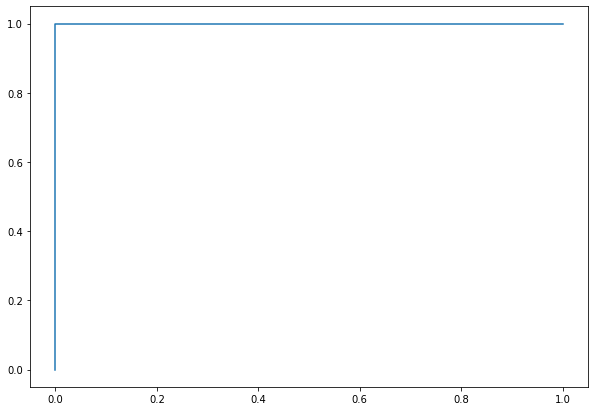

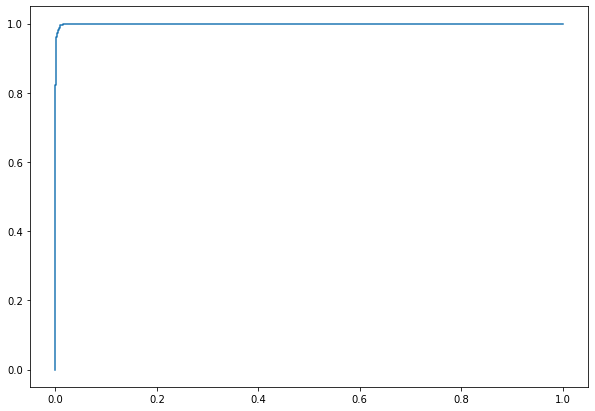

In [84]:
# ROC Train
FPR_train, recall_train, thresholds_train = roc_curve(y_train, xgb_clf.predict_proba(X_train)[:,1], pos_label=1)
#FPR_train, recall_train, thresholds_train = roc_curve(YTrain, result[:,1], pos_label=1)
plt.plot(FPR_train, recall_train)
plt.show()
# ROC Test
FPR_test, recall_test, thresholds_test = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:,1], pos_label=1)
#FPR_test, recall_test, thresholds_test = roc_curve(YTest, result_test[:,1], pos_label=1)
plt.plot(FPR_test, recall_test)
plt.show()

**AUC**

In [85]:
auc_train = roc_auc_score(y_train, xgb_clf.predict(X_train))
auc_test = roc_auc_score(y_test, xgb_clf.predict(X_test))
print("训练集AUC值： ",auc_train)
print("测试集AUC值： ",auc_test)

训练集AUC值：  1.0
测试集AUC值：  0.9796740285004842


**F1**

In [86]:
f1_train = f1_score(y_train,xgb_clf.predict(X_train))
f1_test = f1_score(y_test, xgb_clf.predict(X_test))
print("训练集F1分数： ",f1_train)
print("测试集F1分数： ",f1_test)

训练集F1分数：  1.0
测试集F1分数：  0.9650092081031308


**Confusion Matrix**

In [87]:
confusion_matrix(y_train,xgb_clf.predict(X_train))

array([[37421,     0],
       [    0,  2544]])

In [88]:
confusion_matrix(y_test,xgb_clf.predict(X_test))

array([[16005,    34],
       [   42,  1048]])

**recall**

In [89]:
recall_train = recall_score(y_train,xgb_clf.predict(X_train))
recall_test = recall_score(y_test,xgb_clf.predict(X_test))
print("训练集召回率：",recall_train)
print("测试集召回率：",recall_test)

训练集召回率： 1.0
测试集召回率： 0.9614678899082569


**KS**

In [90]:
fpr,tpr,thresholds= roc_curve(y_test, xgb_clf.predict(X_test), pos_label=1)
print ('KS:',max(tpr-fpr))

KS: 0.9593480570009685


### 使用LIME局部解释查看效果 结果：选取的7个特征在测试集中的平均hit数为2.63

In [20]:
#lime = LimeTabular(predict_fn=xgb_clf.predict_proba, data=X_train)  
#lime_local = lime.explain_local(X_test, y_test)  #解释第0-5样本
#show(lime_local)
from lime.lime_tabular import LimeTabularExplainer
limeexplainer = LimeTabularExplainer(X_train.values,feature_names=X_train.columns,discretize_continuous=True,discretizer="quartile",verbose=True,mode = "classification")
exp = limeexplainer.explain_instance(X_test.iloc[0], xgb_clf.predict_proba, num_features=10)


Intercept 0.09757689658559421
Prediction_local [-0.02511955]
Right: 6.622128e-08


In [ ]:
count = 0
for i in range(X_test.shape[0]):
    count += compare(target_list,lime_local._internal_obj["specific"][i]["names"])
    print(lime_local._internal_obj["specific"][i]["names"])
count /= X_test.shape[0]
count

In [ ]:
def extract_from_exp(exp,columns):
    exp_local = exp.local_exp[1]
    result_list = []
    for i in range(len(exp_local)):
        result_list.append(columns[exp_local[i][0]])
    return result_list
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns)
count = 0
for i in range(X_test.shape[0]):
    exp = explainer.explain_instance(X_test.iloc[i], xgb_clf.predict_proba, num_features=10)
    result_list = extract_from_exp(exp,X_train.columns)
    count += compare(target_list,result_list)
count /= X_test.shape[0]
#show(lime_local)

In [114]:
exp.local_exp[1]

[(39, -0.05999971989457629),
 (5, -0.03257017736444564),
 (90, -0.026731804139571387),
 (62, -0.025556417903239852),
 (81, 0.015063313172601862),
 (30, -0.014263970713046139),
 (87, 0.011582197847462365),
 (31, -0.010723847267593001),
 (78, -0.009946290904418892),
 (27, 0.009171191572112958)]

### 使用SHAP局部解释查看效果 7个特征在测试集中平均hit数为5.54

In [ ]:
'''
shap = ShapKernel(predict_fn=xgb_clf.predict_proba, data=X_train.iloc[:8000],n_jobs=15)  # 多进程用多了内存容易爆
shap_local = shap.explain_local(X_test[:5], y_test[:5])
show(shap_local)
''' #interpretml的可视化会消耗大量时间

In [11]:
import shap
explainer = shap.TreeExplainer(xgb_clf)
#explainer  = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)  # 传入特征矩阵X，计算SHAP值

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [12]:
count = 0
for i in range(len(shap_values)):
    shap_val = shap_values[i]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = X_train.columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    count += compare(target_list,df_new.columns)
count = count / len(shap_values)
count

5.543639441882188

In [ ]:
def plot_sorted_value(shap_values,columns,numberth):
    #plt.rcParams['font.sans-serif'] = ['SimHei']
    #plt.rcParams['axes.unicode_minus'] = False
    shap_val = shap_values[numberth,:]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    #print(type(df_row[df_new.columns].values[0]))
    plt.barh(np.flipud(df_new.columns),np.flipud(df_row[df_new.columns].values[0]))
    plt.xticks(rotation=90)
fig = plt.figure(figsize =(20,15))
pic_num = 11
for i in range(pic_num):
    ax = fig.add_subplot(int(pic_num/2) if pic_num%2==0 else int(pic_num/2) +1,2,i+1)
    plot_sorted_value(shap_values,X_train.columns,i)

### 使用EBMBoosting解释 7个特征在测试集的平均hit数为3.78 但是EBMBoosting解释会产生特征交互

In [13]:
def hit_count(string, target_list): #针对emb存在交互特征的问题
    hit = 0
    for i in target_list:
        index = string.find(i)
        if index != -1:
            hit += 1
    return hit

In [14]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_local = ebm.explain_local(X_test, y_test)
count = 0
for i in range(X_test.shape[0]):
    tmp = pd.DataFrame(np.array(ebm_local._internal_obj["specific"][i]["scores"]).reshape(1,-1),columns = ebm_local._internal_obj["specific"][i]["names"])
    tmp_abs = tmp.copy().abs()
    tmp_result = tmp[tmp_abs.sort_values(by = 0, axis = 1,ascending = False).iloc[:,:10].columns]
    string_combine = ""
    for j in tmp_result.columns:
        string_combine += j
    count += hit_count(string_combine,target_list)
count = count/X_test.shape[0]
count

3.7869694669858136

In [11]:
'''
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_local = ebm.explain_local(X_test.iloc[:5], y_test.iloc[:5])
show(ebm_local)
'''

### 线性生成Label结果图

$y = normalize(0.01 \times x["loan \_ amnt"] + 10\times x["int \_ rate"] + 5\times x["emp \_length"])+ 2 \times    x["grade"]+10\times x["home\_ownership"]+ 0.005 \times x["total\_bc\_limit"] + 0.5 \times x["installment"])$

Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


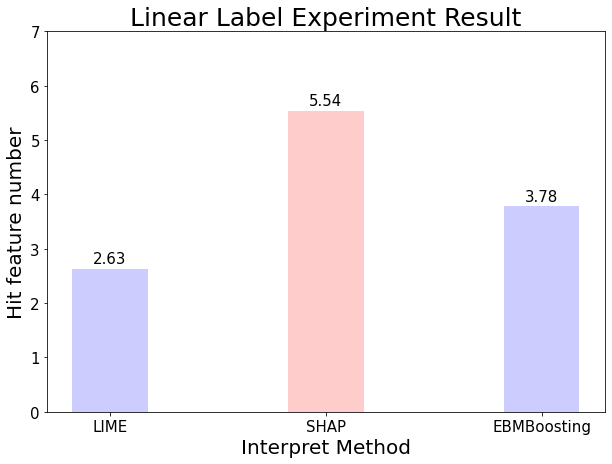

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
name_list = ['LIME','SHAP','EBMBoosting']
num_list = [2.63,5.54,3.78]
for a, b in zip(name_list, num_list):
    ax.text(a, b+0.05, b, ha='center', va='bottom',size = 15)
b = ax.bar(name_list, num_list,width = 0.35,color = 'br',alpha = 0.2)
#ax.text(1, 3.5, r"$y = normalize(0.01 \times x[\"loan \_ amnt\"] + 10\times x[\"int \_ rate\"] + 5\times x[\"emp \_length\"])$",fontsize=20)
#plt.bar(range(len(num_list)), num_list,color='rbg',tick_label=name_list)
plt.title('Linear Label Experiment Result',size = 25)
plt.xlabel('Interpret Method',size = 20)
plt.ylabel('Hit feature number',size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylim(0,7)
plt.rcParams['figure.figsize'] = (10,7)

## 使用一定的非线性生成label

In [50]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))
def tanh(x):
    return 2*sigmoid(2*x)-1
target_list = ["loan_amnt","int_rate","emp_length","sub_grade","mths_since_recent_inq","total_bc_limit","installment"]

$y = normalize( \sqrt{x["loan \_ amnt"]} + \frac{10}{x["int \_ rate"]+\epsilon} +4\times x["sub \_ grade"] + x["emp \_length"]^2)+tanh(x["mths\_since\_last\_delinq]+20 \times sigmoid(x["total\_bc\_limit"])+(0.01\times x["installment"])^3)$

In [51]:
df_norm["target"] = np.sqrt(df_norm["loan_amnt"]) + 10 /(df_norm["int_rate"]+0.0001)+ df_norm["emp_length"]*df_norm["emp_length"]+4*df_norm["sub_grade"]+tanh(df_norm["mths_since_recent_inq"]+20*sigmoid(df_norm["total_bc_limit"])+(0.01*df_norm["installment"])**3)
df_norm["target"] = (normalize(df_norm["target"])>0.5).astype(int)
df_norm["target"].value_counts()

0    41722
1    15372
Name: target, dtype: int64

In [52]:
X,y = df_norm.iloc[:,:-1],df_norm.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
xgb_clf = xgboost.XGBClassifier()
#xgb_lcf = xgboost.XGBRegressor()
xgb_clf.fit(X_train,y_train)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:57:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Accuracy**

In [53]:
xgb_clf.score(X_test,y_test)

0.9959717438262595

**ROC**

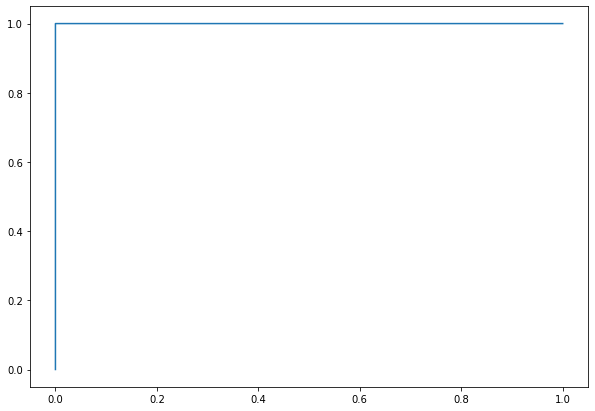

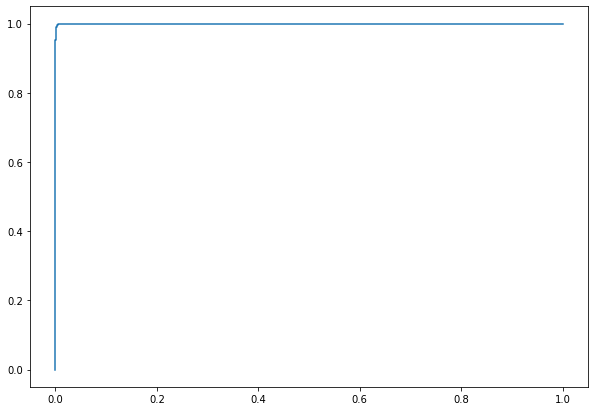

In [54]:
# ROC Train
FPR_train, recall_train, thresholds_train = roc_curve(y_train, xgb_clf.predict_proba(X_train)[:,1], pos_label=1)
#FPR_train, recall_train, thresholds_train = roc_curve(YTrain, result[:,1], pos_label=1)
plt.plot(FPR_train, recall_train)
plt.show()
# ROC Test
FPR_test, recall_test, thresholds_test = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:,1], pos_label=1)
#FPR_test, recall_test, thresholds_test = roc_curve(YTest, result_test[:,1], pos_label=1)
plt.plot(FPR_test, recall_test)
plt.show()

**AUC**

In [55]:
auc_train = roc_auc_score(y_train, xgb_clf.predict(X_train))
auc_test = roc_auc_score(y_test, xgb_clf.predict(X_test))
print("训练集AUC值： ",auc_train)
print("测试集AUC值： ",auc_test)

训练集AUC值：  1.0
测试集AUC值：  0.9944725411947815


**F1**

In [56]:
f1_train = f1_score(y_train,xgb_clf.predict(X_train))
f1_test = f1_score(y_test, xgb_clf.predict(X_test))
print("训练集F1分数： ",f1_train)
print("测试集F1分数： ",f1_test)

训练集F1分数：  1.0
测试集F1分数：  0.9924482871839773


**Confusion Matrix**

In [57]:
confusion_matrix(y_train,xgb_clf.predict(X_train))

array([[29167,     0],
       [    0, 10798]])

In [58]:
confusion_matrix(y_test,xgb_clf.predict(X_test))

array([[12526,    29],
       [   40,  4534]])

**recall**

In [59]:
recall_train = recall_score(y_train,xgb_clf.predict(X_train))
recall_test = recall_score(y_test,xgb_clf.predict(X_test))
print("训练集召回率：",recall_train)
print("测试集召回率：",recall_test)

训练集召回率： 1.0
测试集召回率： 0.9912549191080018


**KS**

In [60]:
fpr,tpr,thresholds= roc_curve(y_test, xgb_clf.predict(X_test), pos_label=1)
print ('KS:',max(tpr-fpr))

KS: 0.9889450823895629


### 使用LIME解释  7个特征在测试集中的平局hit数为4.12

In [15]:
lime = LimeTabular(predict_fn=xgb_clf.predict_proba, data=X_train)
lime_local = lime.explain_local(X_test.iloc[:5], y_test.iloc[:5])

show(lime_local)

### 使用SHAP解释 7个特征在测试集中的平局hit数为4.89

In [35]:
import shap
explainer = shap.TreeExplainer(xgb_clf)
#explainer  = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)  # 传入特征矩阵X，计算SHAP值

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [36]:
count = 0
for i in range(len(shap_values)):
    shap_val = shap_values[i]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = X_train.columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    count += compare(target_list,df_new.columns)
count = count / len(shap_values)
count

4.891120322260494

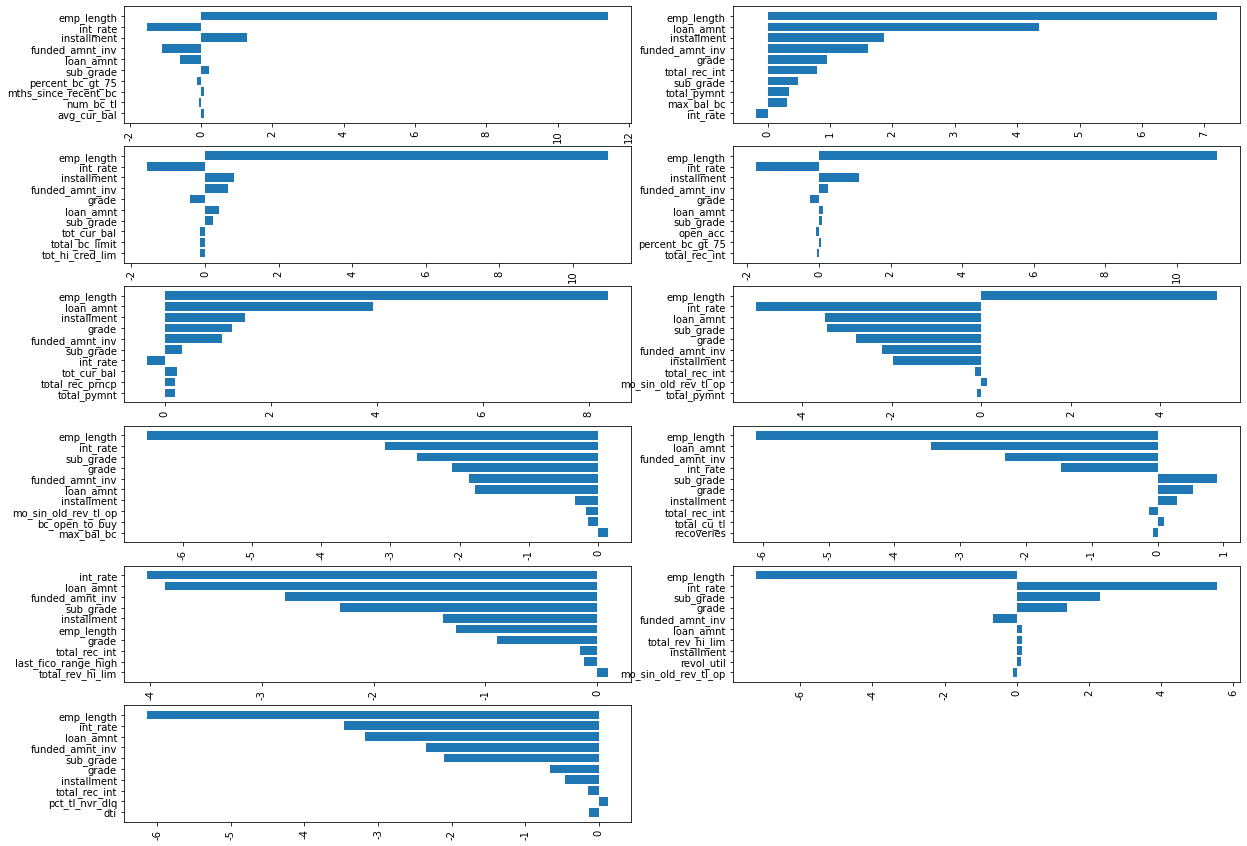

In [30]:
def plot_sorted_value(shap_values,columns,numberth):
    #plt.rcParams['font.sans-serif'] = ['SimHei']
    #plt.rcParams['axes.unicode_minus'] = False
    shap_val = shap_values[numberth,:]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    #print(type(df_row[df_new.columns].values[0]))
    plt.barh(np.flipud(df_new.columns),np.flipud(df_row[df_new.columns].values[0]))
    plt.xticks(rotation=90)
fig = plt.figure(figsize =(20,15))
pic_num = 11
for i in range(pic_num):
    ax = fig.add_subplot(int(pic_num/2) if pic_num%2==0 else int(pic_num/2) +1,2,i+1)
    plot_sorted_value(shap_values,X_train.columns,i)

### EBMBoosting 7个特征在随机选取的测试集中的平局hit数为4.27

In [38]:
def hit_count(string, target_list): #针对emb存在交互特征的问题
    hit = 0
    for i in target_list:
        index = string.find(i)
        if index != -1:
            hit += 1
    return hit
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_local = ebm.explain_local(X_test, y_test)
count = 0
for i in range(X_test.shape[0]):
    tmp = pd.DataFrame(np.array(ebm_local._internal_obj["specific"][i]["scores"]).reshape(1,-1),columns = ebm_local._internal_obj["specific"][i]["names"])
    tmp_abs = tmp.copy().abs()
    tmp_result = tmp[tmp_abs.sort_values(by = 0, axis = 1,ascending = False).iloc[:,:10].columns]
    string_combine = ""
    for j in tmp_result.columns:
        string_combine += j
    count += hit_count(string_combine,target_list)
count = count/X_test.shape[0]
count

4.270009924689123

Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


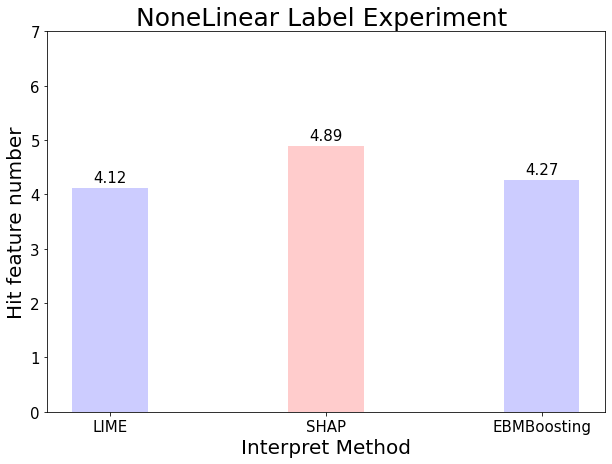

In [121]:
fig, ax = plt.subplots()
name_list = ['LIME','SHAP','EBMBoosting']
num_list = [4.12,4.89,4.27]
for a, b in zip(name_list, num_list):
    ax.text(a, b+0.05, b, ha='center', va='bottom',size = 15)
b = ax.bar(name_list, num_list,width = 0.35,color = 'br',alpha = 0.2)
#ax.text(1, 3.5, r"$y = normalize(0.01 \times x[\"loan \_ amnt\"] + 10\times x[\"int \_ rate\"] + 5\times x[\"emp \_length\"])$",fontsize=20)
#plt.bar(range(len(num_list)), num_list,color='rbg',tick_label=name_list)
plt.title('NoneLinear Label Experiment ',size = 25)
plt.xlabel('Interpret Method',size = 20)
plt.ylabel('Hit feature number',size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylim(0,7)
plt.rcParams['figure.figsize'] = (10,7)

## 交互特征

$y = normalize(log(x["loan\_amnt"]+0.5 \times x["annual\_inc"])+0.01 \times x["loan\_amnt"] \times x["int\_rate"] + 0.03 \times (0.001 \times x["total\_rec\_prncp"]+0.001 \times x["total\_rec\_int"])^2)$

In [61]:
target_list = ["loan_amnt","annual_inc","int_rate","total_rec_prncp","total_rec_int"]

In [62]:
import math
df_norm["target"] = (df_norm["loan_amnt"]+0.5*df_norm["annual_inc"]).apply(np.log1p)+0.01*df_norm["loan_amnt"]*df_norm["int_rate"]+0.03*(0.001*df_norm["total_rec_prncp"]+0.001*df_norm["total_rec_int"])**2
df_norm["target"] = (normalize(df_norm["target"])>0.4).astype(int)
df_norm["target"].value_counts()

0    52449
1     4645
Name: target, dtype: int64

In [63]:
X,y = df_norm.iloc[:,:-1],df_norm.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
xgb_clf = xgboost.XGBClassifier()
#xgb_lcf = xgboost.XGBRegressor()
xgb_clf.fit(X_train,y_train)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:02:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Accuracy**

In [64]:
xgb_clf.score(X_test,y_test)

0.9995913363302003

**ROC**

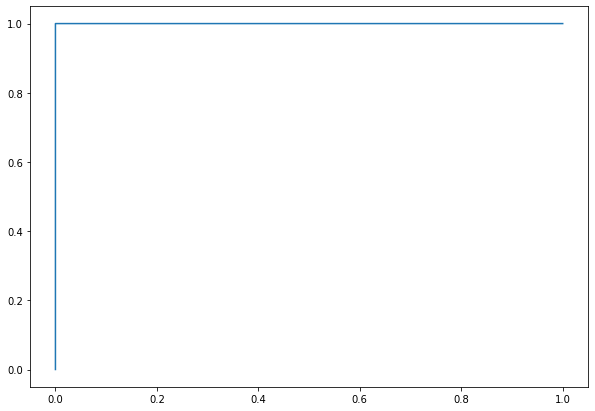

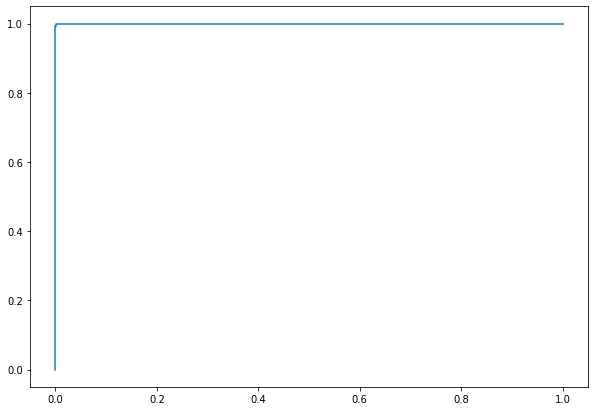

In [65]:
# ROC Train
FPR_train, recall_train, thresholds_train = roc_curve(y_train, xgb_clf.predict_proba(X_train)[:,1], pos_label=1)
#FPR_train, recall_train, thresholds_train = roc_curve(YTrain, result[:,1], pos_label=1)
plt.plot(FPR_train, recall_train)
plt.show()
# ROC Test
FPR_test, recall_test, thresholds_test = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:,1], pos_label=1)
#FPR_test, recall_test, thresholds_test = roc_curve(YTest, result_test[:,1], pos_label=1)
plt.plot(FPR_test, recall_test)
plt.show()

**AUC**

In [66]:
auc_train = roc_auc_score(y_train, xgb_clf.predict(X_train))
auc_test = roc_auc_score(y_test, xgb_clf.predict(X_test))
print("训练集AUC值： ",auc_train)
print("测试集AUC值： ",auc_test)

训练集AUC值：  1.0
测试集AUC值：  0.9991409742682291


**F1**

In [67]:
f1_train = f1_score(y_train,xgb_clf.predict(X_train))
f1_test = f1_score(y_test, xgb_clf.predict(X_test))
print("训练集F1分数： ",f1_train)
print("测试集F1分数： ",f1_test)

训练集F1分数：  1.0
测试集F1分数：  0.9975533030408948


**Confusion Matrix**

In [68]:
confusion_matrix(y_train,xgb_clf.predict(X_train))

array([[36749,     0],
       [    0,  3216]])

In [69]:
confusion_matrix(y_test,xgb_clf.predict(X_test))

array([[15695,     5],
       [    2,  1427]])

**recall**

In [70]:
recall_train = recall_score(y_train,xgb_clf.predict(X_train))
recall_test = recall_score(y_test,xgb_clf.predict(X_test))
print("训练集召回率：",recall_train)
print("测试集召回率：",recall_test)

训练集召回率： 1.0
测试集召回率： 0.9986004198740378


**KS**

In [71]:
fpr,tpr,thresholds= roc_curve(y_test, xgb_clf.predict(X_test), pos_label=1)
print ('KS:',max(tpr-fpr))

KS: 0.9982819485364581


### 使用LIME解释 5个特征在测试集中的平均hit数为1.63

### 使用SHAP解释 5个特征在测试集中的平局hit数为3.12

In [18]:
import shap
explainer = shap.TreeExplainer(xgb_clf)
#explainer  = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)  # 传入特征矩阵X，计算SHAP值
count = 0
for i in range(len(shap_values)):
    shap_val = shap_values[i]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = X_train.columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    count += compare(target_list,df_new.columns)
count = count / len(shap_values)
count

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


3.120789304687956

### EBMBoosting 7个特征在随机选取的测试集中的平局hit数为2.26

In [19]:
def hit_count(string, target_list): #针对emb存在交互特征的问题
    hit = 0
    for i in target_list:
        index = string.find(i)
        if index != -1:
            hit += 1
    return hit
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_local = ebm.explain_local(X_test, y_test)
count = 0
for i in range(X_test.shape[0]):
    tmp = pd.DataFrame(np.array(ebm_local._internal_obj["specific"][i]["scores"]).reshape(1,-1),columns = ebm_local._internal_obj["specific"][i]["names"])
    tmp_abs = tmp.copy().abs()
    tmp_result = tmp[tmp_abs.sort_values(by = 0, axis = 1,ascending = False).iloc[:,:10].columns]
    string_combine = ""
    for j in tmp_result.columns:
        string_combine += j
    count += hit_count(string_combine,target_list)
count = count/X_test.shape[0]
count

2.2263996730690643

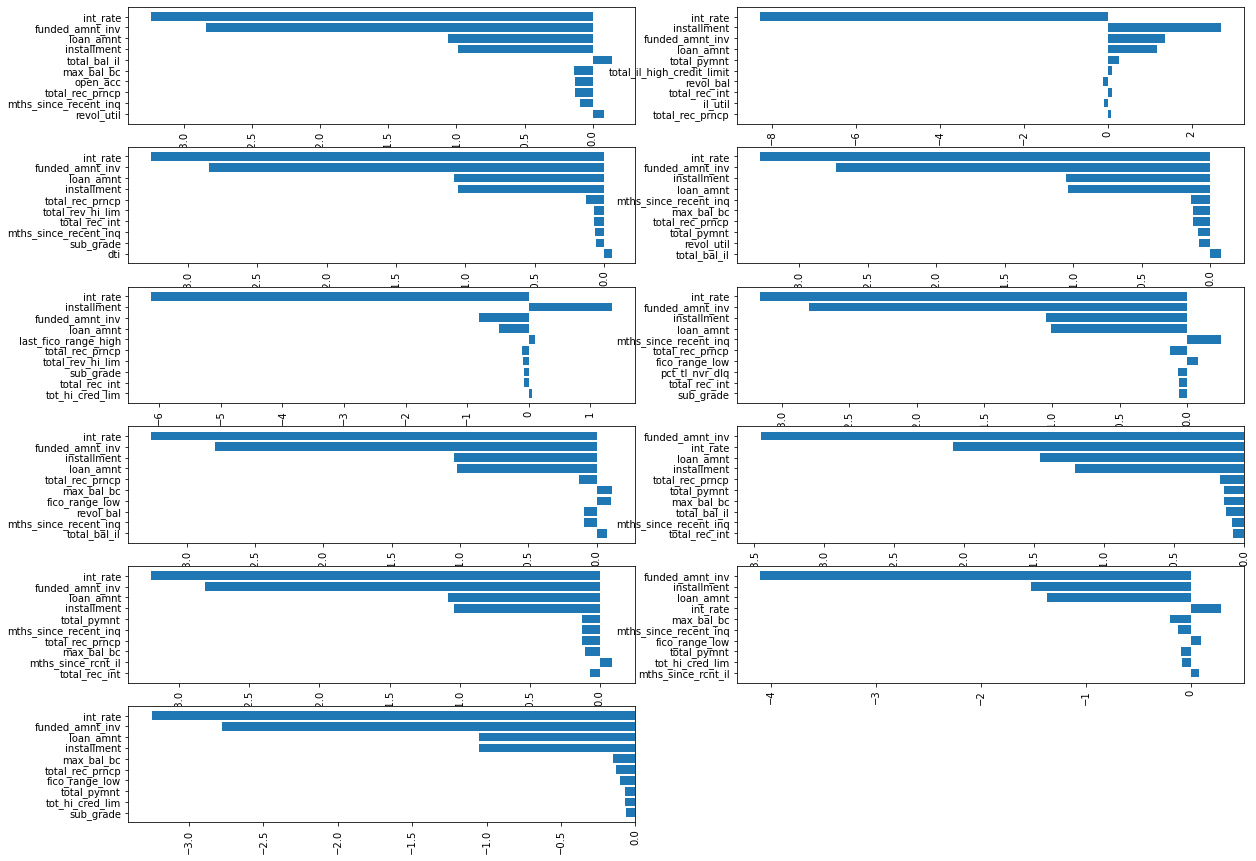

In [20]:
def plot_sorted_value(shap_values,columns,numberth):
    #plt.rcParams['font.sans-serif'] = ['SimHei']
    #plt.rcParams['axes.unicode_minus'] = False
    shap_val = shap_values[numberth,:]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    #print(type(df_row[df_new.columns].values[0]))
    plt.barh(np.flipud(df_new.columns),np.flipud(df_row[df_new.columns].values[0]))
    plt.xticks(rotation=90)
fig = plt.figure(figsize =(20,15))
pic_num = 11
for i in range(pic_num):
    ax = fig.add_subplot(int(pic_num/2) if pic_num%2==0 else int(pic_num/2) +1,2,i+1)
    plot_sorted_value(shap_values,X_train.columns,i)

Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


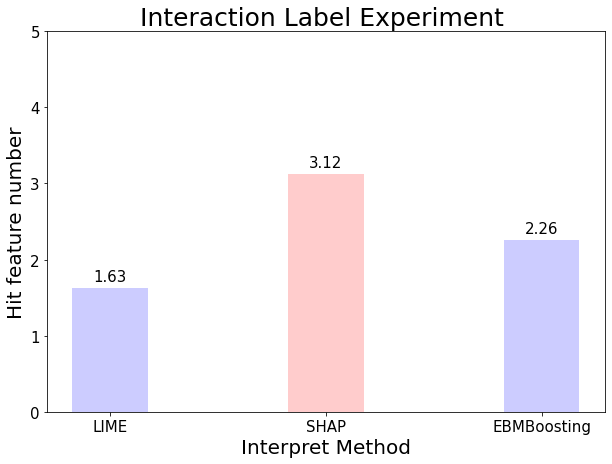

In [22]:
fig, ax = plt.subplots()
name_list = ['LIME','SHAP','EBMBoosting']
num_list = [1.63,3.12,2.26]
for a, b in zip(name_list, num_list):
    ax.text(a, b+0.05, b, ha='center', va='bottom',size = 15)
b = ax.bar(name_list, num_list,width = 0.35,color = 'br',alpha = 0.2)
#ax.text(1, 3.5, r"$y = normalize(0.01 \times x[\"loan \_ amnt\"] + 10\times x[\"int \_ rate\"] + 5\times x[\"emp \_length\"])$",fontsize=20)
#plt.bar(range(len(num_list)), num_list,color='rbg',tick_label=name_list)
plt.title('Interaction Label Experiment ',size = 25)
plt.xlabel('Interpret Method',size = 20)
plt.ylabel('Hit feature number',size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylim(0,5)
plt.rcParams['figure.figsize'] = (10,7)

**初步分析**
- 添加构成target特征数量后，各方法hit比例均有一定下降
- 选用SHAP.TreeExplainer替代SHAP.kernelExplainer，时间复杂度大幅下降,因此将实验验证数据集设定为测试集(17129,94)
- 现在的主要局限是LIME的解释时间复杂度，解释一个样本约需要30秒，解释整个测试集需要142小时
- 使用多线程LIME，16线程，约需要17小时
- 特征增加后LIME的解释效果相比另外两项差距较大
- 分析数据后发现数据集中部分列存在强相关性，因此推断经过特征筛选后再进行可解释实验可以得到更好的解释效果
- 目前结果是SHAP>EBMBoosting>LIME
- 解释效果 Linear>Nonlinear>Interaction